In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)
meta = pd.read_csv("meta.csv")
cred = pd.read_csv("credits.csv")

C:\Users\Public\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



# PART 1: Some Basic EDA


In [2]:
# we have 45466 observations of movies, of among these observations
# get the subset of data for the recent 10 years, 12731 remaining observations.
# 668  French Movies.
metaSub = meta[(meta['release_date'] > '2010-01-01') & (meta['release_date'] < '2020-01-01')]
meta1 = metaSub[metaSub['original_language'] == 'fr']

# Part2: Data Preprocessing

In [3]:
# join with credits to get director and cast information.
cred.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
meta1['id'] = pd.to_numeric(meta1['id'])
meta2 = meta1.merge(cred, how = "left", on=  "id")
meta2.columns

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

# Part3: Feature Engineering 

In [5]:
# note: there is some problem with reading json format, so I use some brute force methods as a workaround. 

In [6]:
# get genre
meta2['genres'] = meta2['genres'].str.replace("\'", "\"")
import json
meta2['genres2'] = meta2['genres'].apply(json.loads)
for i in range(0, len(meta2['genres2'])):
   
    try:
#         print(meta2['genres2'].loc[i][0]['name'])
        meta2['genres2'].loc[i] = meta2['genres2'].loc[i][0]['name']
    except:
        meta2['genres2'].loc[i] = "None"


C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# get Director:
meta2['director'] = ''
meta2['crew'] = meta2['crew'].str.replace("\'", "\"")
# meta2['crew'].apply(json.loads)
a = list(meta2['crew'].loc[0].split(sep = ','))
identifier = a[4]
for j in range(0, len(meta2['crew'])):
    myStr = list(meta2['crew'].loc[j].split(sep = ','))
    for i in range(0, len(myStr)):
        if myStr[i]== identifier :
            meta2['director'].loc[j]  = myStr[i+1].strip('"name": "')


In [8]:
# get top cast
meta2['cast1'] = ''
meta2['cast2'] = ''

meta2['cast'] = meta2['cast'].str.replace("\'", "\"")
meta2['cast'] = meta2['cast'].str[0:500]

# a = list(meta2['cast'].loc[0].split(sep = '}, {'))
# a[0]
# b = a[0].split(sep = ',')
# b[5]
# b[5].startswith(' "name"')
for j in range(0, len(meta2['cast'])):
    myStr = list(meta2['cast'].loc[j].split(sep = '}, {'))
    try:
        myStr0 = list(myStr[0].split(sep = ','))
        myStr1 = list(myStr[1].split(sep = ','))
        twochar = True 
    except:
        myStr0 = list(myStr[0].split(sep = ','))
        twochar = False
        
    for i in range(0, len(myStr0)):
        if myStr0[i].startswith(' "name"'):
            meta2['cast1'].loc[j] = myStr0[i].strip('"name": "')
    
    if twochar == True:
        for i in range(0, len(myStr1)):
            if myStr1[i].startswith(' "name"'):
                meta2['cast2'].loc[j] = myStr1[i].strip('"name": "')

                
# get the top 26 most popular stars
topcast1 = meta2['cast1'].value_counts()[0:15].index[1:].tolist()
topcast2 = meta2['cast2'].value_counts()[0:15].index[1:].tolist()                 

topcast2.extend(topcast1)
topcast = list(set(topcast2))

# if the movie has the topcast stars as cast, then it "hasStar"
def hasStar(x):

    if (x[0] in topcast) or (x[1] in topcast):
        return 1
    else:
        return 0

meta2['hasStar'] = meta2[['cast1', 'cast2']].apply(hasStar, axis =1)
meta2['hasStar']

0      1
1      1
2      0
3      1
4      0
      ..
665    0
666    1
667    1
668    1
669    0
Name: hasStar, Length: 670, dtype: int64

In [9]:
# get number of spoken language
meta2['numSpokenLan'] = ''


for j in range(0, len(meta2['spoken_languages'])):
    myStr = list(meta2['crew'].loc[j].split(sep = "}, {"))
    meta2['numSpokenLan'].loc[j] = len(myStr)
#     print(meta2['numSpokenLan'].loc[j])
    

# get a binary identifier for movies that has been spoken in more than 3 languages
def has3PlusLang(x):
    if x > 2:
        return 1
    else:
        return 0

meta2["has3PlusLang"] = meta2["numSpokenLan"].apply(has3PlusLang)




In [10]:
# get blockbuster directors : this column is problematic due to data leakage issue and thus is not used. 
# meta2['popularity'].astype(float).max()
# meta2['popularity'].astype(float).mean()

# # if the movie is in top 0.5 percentile for popularity, then the director is considered a block buster director.
# def isBlockBuster(x):
#     onePct = meta2['vote_count'].astype(float).quantile(0.95)
#     if x> onePct:
#         return 1
#     else:
#         return 0
    

# meta2['isBlockBuster']  = meta2['vote_count'].astype(float).apply(isBlockBuster)
# blockBusterDirList = meta2['director'][meta2['isBlockBuster'] == 1].unique()

# def hasBlockBusterDirector(x):
#     if x in blockBusterDirList:
#         return 1
#     else:
#         return 0
    
# meta2['hasBlockBusterDirector'] = meta2['director'].apply(hasBlockBusterDirector)


# get big directors who directed a lot of movies
topdir = meta2['director'].value_counts()[0:20].index[1:].tolist()


# # if the movie has a director that is in the top director list then it "hasbigDir"
def hasbigDir(x):

    if (x in topdir):
        return 1
    else:
        return 0

meta2['hasbigDir'] = meta2['director'].apply(hasbigDir)
len(meta2[meta2['hasbigDir']==1])

68

In [11]:
# get only released films.
meta3 = meta2[meta2['status'] == 'Released']

In [12]:
# get columns
meta4 = meta3[[  'vote_average', 'vote_count','id','popularity','budget','revenue','adult', 
        'original_language', 'original_title',
        'production_companies',
        'production_countries', 'release_date',  'runtime',
        'spoken_languages', 
        'genres2', 'director', 'cast1', 'cast2', 'numSpokenLan', 'hasStar', 'has3PlusLang', 'hasbigDir']]




In [13]:
meta4 = meta3[['popularity','adult', 
        'runtime', 
        'genres2', 'numSpokenLan','has3PlusLang', 'hasStar', 'hasbigDir']]

In [14]:
# get dummy from 19 genres
a = pd.get_dummies(meta4['genres2'])
meta5 = meta4.copy()
colnames = list(a.columns)
meta5[colnames] = a
meta5.head()

,popularity,adult,runtime,genres2,numSpokenLan,has3PlusLang,hasStar,hasbigDir,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,TV Movie,Thriller,War
0,0.134014,False,95.0,Drama,17,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.134014,False,95.0,Drama,17,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2.66762,False,79.0,Documentary,6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.7106,False,105.0,Fantasy,8,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,11.0214,False,130.0,Drama,14,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
def isAdult(x):
    if x == 'False':
        return 0
    if x == 'True':
        return 1
    else:
        return None
    
meta5['adult'] = meta5['adult'].apply(isAdult)


meta5['runtime'].median()
def isLongerMovie(x):
    if x > 100:
        return 1
    else:
        return 0
    
meta5['isLongerMovie'] = meta5['runtime'].apply(isLongerMovie)
meta5 = meta5.drop(columns = ['runtime', 'adult', 'genres2', 'numSpokenLan'])

In [16]:
meta5.columns

Index(['popularity', 'has3PlusLang', 'hasStar', 'hasbigDir', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'None',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'isLongerMovie'],
      dtype='object')

In [17]:
meta5.head()

,popularity,has3PlusLang,hasStar,hasbigDir,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,TV Movie,Thriller,War,isLongerMovie
0,0.134014,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.134014,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.66762,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.7106,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,11.0214,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


# Part 4: Random Forest and Feature Importance Analysis

In [25]:
# reference: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

from sklearn.model_selection import train_test_split
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(meta5['popularity'])
# Remove the labels from the features
# axis 1 refers to the columns
features= meta5.drop('popularity', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [26]:
test_labels = test_labels.astype(np.float)

In [27]:
# reference: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    

Mean Absolute Error: 2.11 degrees.


In [ ]:
# reference: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
# cannot run this code in jupyter notebook with Anaconda, used Google Colab


# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10000, max_depth = 10)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [30]:
# reference: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: has3PlusLang         Importance: 0.19
Variable: isLongerMovie        Importance: 0.16
Variable: hasStar              Importance: 0.11
Variable: hasbigDir            Importance: 0.11
Variable: Comedy               Importance: 0.09
Variable: Action               Importance: 0.05
Variable: Adventure            Importance: 0.05
Variable: Drama                Importance: 0.04
Variable: Crime                Importance: 0.03
Variable: Documentary          Importance: 0.03
Variable: Family               Importance: 0.02
Variable: History              Importance: 0.02
Variable: Thriller             Importance: 0.02
Variable: Animation            Importance: 0.01
Variable: Fantasy              Importance: 0.01
Variable: Music                Importance: 0.01
Variable: Mystery              Importance: 0.01
Variable: Romance              Importance: 0.01
Variable: War                  Importance: 0.01
Variable: Horror               Importance: 0.0
Variable: None                 Importance

In [32]:
importantFeatures = feature_importances[0:10]
importantFeatures

[('has3PlusLang', 0.19),
 ('isLongerMovie', 0.16),
 ('hasStar', 0.11),
 ('hasbigDir', 0.11),
 ('Comedy', 0.09),
 ('Action', 0.05),
 ('Adventure', 0.05),
 ('Drama', 0.04),
 ('Crime', 0.03),
 ('Documentary', 0.03)]

# Part 5: k-means Clustering: dicover what features make a popular movie

In [33]:
# input Feature for clustering method. 
myCandidates = [x[0] for x in importantFeatures]
meta7 = meta5[myCandidates]
meta7['popularity'] = meta5['popularity']


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [100]:
# scale data
# reference: https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
a = min_max_scaler.fit_transform(meta7[['popularity','Documentary']])
popMinMax = [x[0] for x in a]

# stretch popularity by a fator of 3 for higher importance in clustering. 
popMinMax = [x*3 for x in popMinMax]
meta7['popMinMax'] = popMinMax

meta8  = meta7.drop(columns = 'popularity')
meta8.head()

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,has3PlusLang,isLongerMovie,hasStar,hasbigDir,Comedy,Action,Adventure,Drama,Crime,Documentary,popMinMax
0,1,0,1,0,0,0,0,1,0,0,0.019405
1,1,0,1,0,0,0,0,1,0,0,0.019405
2,1,0,0,0,0,0,0,0,0,1,0.406772
3,1,1,1,0,0,0,0,0,0,0,1.024910
4,1,1,0,0,0,0,0,1,0,0,1.683991


In [101]:
# kmeans Clustering 
# reference: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

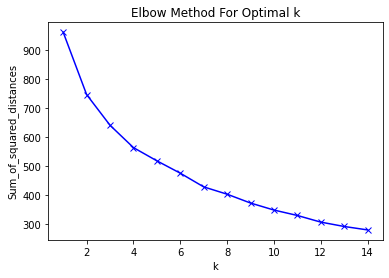

In [102]:
# determine the optimal number of clusters with the The Elbow Method

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(meta8)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [103]:
# reference: https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(meta8)
y_km

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1,
       1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 0, 1, 2, 1, 1, 0, 1, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 0, 2, 0, 1,
       2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1,
       2, 2, 0, 1, 1, 0, 2, 1, 2, 1, 2, 0, 2, 2, 2, 1, 0, 1, 1, 2, 0, 2,
       1, 2, 2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 2, 2, 0, 0, 2, 0, 0, 2, 1, 1,
       1, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 1, 0, 1, 0, 2, 2, 2,
       0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0,
       0, 2, 0, 2, 1, 1, 2, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1,
       0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 2, 0,
       0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1,
       2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0,

In [104]:
# append label to df
meta8['clusterLabel'] = y_km.tolist()
meta8.head()

,has3PlusLang,isLongerMovie,hasStar,hasbigDir,Comedy,Action,Adventure,Drama,Crime,Documentary,popMinMax,clusterLabel
0,1,0,1,0,0,0,0,1,0,0,0.019405,0
1,1,0,1,0,0,0,0,1,0,0,0.019405,0
2,1,0,0,0,0,0,0,0,0,1,0.406772,0
3,1,1,1,0,0,0,0,0,0,0,1.024910,1
4,1,1,0,0,0,0,0,1,0,0,1.683991,1


In [105]:
# visualize clustering results


In [106]:
# Cluster_1 = meta7[meta7["clusterLabel"] == 0]
# Cluster_2 = meta7[meta7["clusterLabel"] == 1]
# # Cluster_3 = meta7[meta7["clusterLabel"] == 2]
# # Cluster_4 = meta7[meta7["clusterLabel"] == 3]

In [107]:
meta8['popMinMax'] = meta8['popMinMax'].astype(float)

In [108]:
# summerize cluster characteristics

clusterChar = meta8.groupby('clusterLabel').agg({ 'popMinMax':'mean', 'has3PlusLang': 'mean', 'isLongerMovie': 'mean',
                                                   'hasStar':'mean', 'Comedy': 'mean','hasbigDir':'mean', 'Adventure':'mean',
                                                   'Drama':'mean', "Action": 'mean','Documentary':'mean'})


clusterChar

,popMinMax,has3PlusLang,isLongerMovie,hasStar,Comedy,hasbigDir,Adventure,Drama,Action,Documentary
clusterLabel,,,,,,,,,,
0,0.314683,0.757576,0.026515,0.185606,0,0.075758,0.037879,0.481061,0.034091,0.109848
1,0.747359,0.910995,0.931937,0.282723,0,0.125654,0.015707,0.738220,0.047120,0.015707
2,0.546670,0.746411,0.277512,0.253589,1,0.114833,0.000000,0.000000,0.000000,0.000000
